# Analysis of comment moderation results (A/B/C policies)

This notebook:

- Loads:
  - `../data/comments.csv`
  - `../results/comments_with_policy_results.csv`
- Computes:
  - Overall distribution of decisions (BLOCK / WARN_AND_ALLOW / ALLOW) per policy
  - Average tone and debate-value scores per policy
  - Decision maps in tone–debate space (scatter + BLOCK probability heatmap)
  - Cases where policies disagree (e.g., A=BLOCK, C=ALLOW)
- Produces:
  - Summary tables (for slides / report)
  - Optional simple visualizations (bar charts, scatter plots, heatmaps) using matplotlib

Assumptions:

- This notebook is located in `notebooks/` directory of the project.
- Folder structure:

    project_root 
             
      ├─ data/ 
      │   └─ comments.csv 
      ├─ results/ 
      │   └─ comments_with_policy_results.csv 
      └─ notebooks/ 
          └─ analysis_comments_results.ipynb (this file)


In [1]:
# Standard imports
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set up paths assuming this notebook is in `notebooks/`
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"

COMMENTS_CSV = DATA_DIR / "comments.csv"
RESULTS_CSV = RESULTS_DIR / "comments_with_policy_results.csv"

print("Project root :", PROJECT_ROOT)
print("Comments CSV :", COMMENTS_CSV)
print("Results CSV  :", RESULTS_CSV)


Project root : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_비밀게시판
Comments CSV : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_비밀게시판\data\comments.csv
Results CSV  : C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_비밀게시판\results\comments_with_policy_results.csv


In [2]:
# Load original comments (one row per sample_id)
comments_df = pd.read_csv(COMMENTS_CSV)
print(f"Loaded {len(comments_df)} rows from comments.csv")
display(comments_df.head())

# Load policy results (one row per sample_id x policy)
results_df = pd.read_csv(RESULTS_CSV)
print(f"Loaded {len(results_df)} rows from comments_with_policy_results.csv")
display(results_df.head())

# Merge results with original text so that every row has the comment text
merged_df = results_df.merge(
    comments_df[["sample_id", "thread_id", "role", "order_in_thread", "text"]],
    on=["sample_id", "thread_id", "role", "order_in_thread"],
    how="left",
    suffixes=("", "_orig"),
)

print(f"Merged rows: {len(merged_df)}")
display(merged_df.head())


Loaded 126 rows from comments.csv


,sample_id,thread_id,role,order_in_thread,text
0,1,1,post,0,핼스장 팬티 오늘도 다른 사람이 벗어둔거 킁킁해서 기분 좋다
1,2,1,comment,1,헬스장에서 팬티를 왜 벗음
2,3,1,comment,2,게이게이야..
3,4,2,post,0,어효 코스프레하는 애들은 하나같이 젖크고 얼굴 이쁘고 빼빼 말랐네
4,5,2,comment,1,학교에 있음?


Loaded 378 rows from comments_with_policy_results.csv


,sample_id,thread_id,role,order_in_thread,policy,decision,short_reason,tone_score,debate_value_score
0,1,1,post,0,A,BLOCK,The comment implies inappropriate and invasive...,4,1
1,1,1,post,0,B,BLOCK,The comment describes inappropriate behavior t...,4,1
2,1,1,post,0,C,BLOCK,The comment depicts invasive and inappropriate...,4,1
3,2,1,comment,1,A,ALLOW,The comment is a neutral question without insu...,2,2
4,2,1,comment,1,B,ALLOW,The comment is a neutral inquiry without perso...,2,2


Merged rows: 378


,sample_id,thread_id,role,order_in_thread,policy,decision,short_reason,tone_score,debate_value_score,text
0,1,1,post,0,A,BLOCK,The comment implies inappropriate and invasive...,4,1,핼스장 팬티 오늘도 다른 사람이 벗어둔거 킁킁해서 기분 좋다
1,1,1,post,0,B,BLOCK,The comment describes inappropriate behavior t...,4,1,핼스장 팬티 오늘도 다른 사람이 벗어둔거 킁킁해서 기분 좋다
2,1,1,post,0,C,BLOCK,The comment depicts invasive and inappropriate...,4,1,핼스장 팬티 오늘도 다른 사람이 벗어둔거 킁킁해서 기분 좋다
3,2,1,comment,1,A,ALLOW,The comment is a neutral question without insu...,2,2,헬스장에서 팬티를 왜 벗음
4,2,1,comment,1,B,ALLOW,The comment is a neutral inquiry without perso...,2,2,헬스장에서 팬티를 왜 벗음


## 1. Decision distribution per policy

Decision counts per policy:


decision,ALLOW,BLOCK,WARN_AND_ALLOW
policy,,,
A,95,26,5
B,97,13,16
C,113,6,7


Decision percentages per policy (%):


decision,ALLOW,BLOCK,WARN_AND_ALLOW
policy,,,
A,75.4,20.6,4.0
B,77.0,10.3,12.7
C,89.7,4.8,5.6


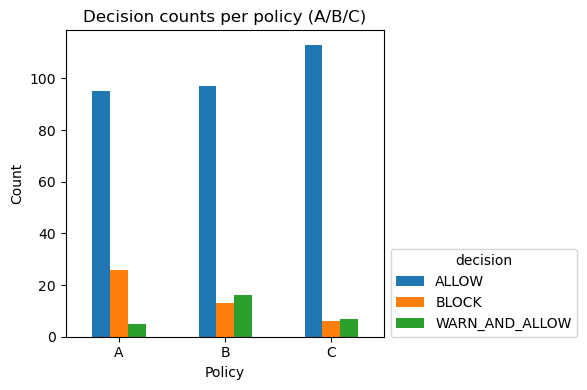

In [3]:
# Decision counts per policy
decision_summary = (
    merged_df
    .groupby(["policy", "decision"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

print("Decision counts per policy:")
display(decision_summary)

# Also compute row-wise percentages
decision_pct = decision_summary.div(decision_summary.sum(axis=1), axis=0) * 100
print("Decision percentages per policy (%):")
display(decision_pct.round(1))

# Simple bar chart for decision distribution per policy
# (Uses matplotlib only, no custom colors)
ax = decision_summary.plot(
    kind="bar",
    rot=0,
    figsize=(6, 4),
)
ax.set_xlabel("Policy")
ax.set_ylabel("Count")
ax.set_title("Decision counts per policy (A/B/C)")
ax.legend(
    title="decision",
    loc="lower left",
    bbox_to_anchor=(1.02, 0),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


## 2. Average tone_score and debate_value_score per policy

Average tone_score and debate_value_score per policy:


,tone_score,debate_value_score
policy,,
A,2.02,1.54
B,2.01,1.59
C,1.99,1.59


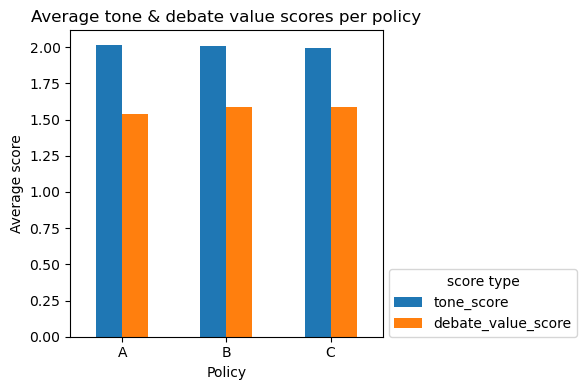

In [4]:
# Average scores per policy
score_summary = (
    merged_df
    .groupby("policy")[["tone_score", "debate_value_score"]]
    .mean()
    .sort_index()
)

print("Average tone_score and debate_value_score per policy:")
display(score_summary.round(2))

# Bar plots for scores (optional)
ax = score_summary.plot(
    kind="bar",
    rot=0,
    figsize=(6, 4),
)
ax.set_xlabel("Policy")
ax.set_ylabel("Average score")
ax.set_title("Average tone & debate value scores per policy")
ax.legend(
    title="score type",
    loc="lower left",
    bbox_to_anchor=(1.02, 0),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


## 3. Decision maps in tone–debate space

In this section, we visualize how each policy (A/B/C) makes moderation decisions
across the 2D space of **tone_score** (1 = polite, 5 = aggressive) and
**debate_value_score** (1 = low, 5 = high).

We first draw scatter plots (one panel per policy), and then heatmaps showing
the probability of **BLOCK** in each (tone, debate) cell. This reveals which
regions of the space each policy tends to treat more harshly (high BLOCK rate)
or more leniently.


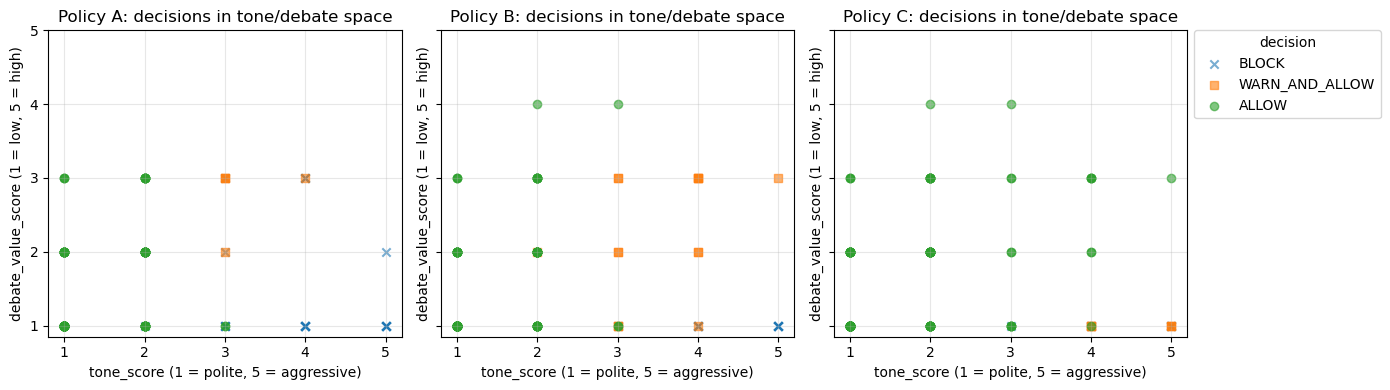

In [5]:
# 3.1 Scatter: decision by tone_score & debate_value_score for each policy

policies = ["A", "B", "C"]
decisions = ["BLOCK", "WARN_AND_ALLOW", "ALLOW"]
markers = {
    "BLOCK": "x",
    "WARN_AND_ALLOW": "s",
    "ALLOW": "o",
}

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

for ax, pol in zip(axes, policies):
    sub = merged_df[merged_df["policy"] == pol].copy()
    # Drop rows with missing scores
    sub = sub.dropna(subset=["tone_score", "debate_value_score"])

    for dec in decisions:
        sub_dec = sub[sub["decision"] == dec]
        if sub_dec.empty:
            continue
        ax.scatter(
            sub_dec["tone_score"],
            sub_dec["debate_value_score"],
            alpha=0.6,
            marker=markers[dec],
            label=dec,
        )

    ax.set_title(f"Policy {pol}: decisions in tone/debate space")
    ax.set_xlabel("tone_score (1 = polite, 5 = aggressive)")
    ax.set_ylabel("debate_value_score (1 = low, 5 = high)")
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.grid(True, alpha=0.3)

# Legend shown once, on the right of the last panel
axes[-1].legend(
    title="decision",
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21216\1645278950.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


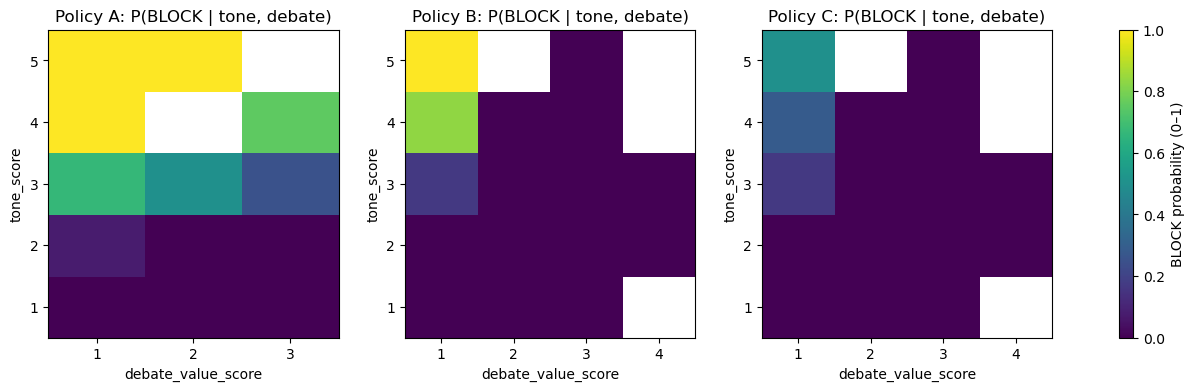

In [6]:
# 3.2 Heatmaps: P(BLOCK | tone_score, debate_value_score) per policy

def make_block_rate_heatmap(df, policy_id):
    """
    Compute P(BLOCK | tone_score, debate_value_score) for a given policy.

    Returns:
        tones: sorted list of tone_score values
        debates: sorted list of debate_value_score values
        block_rate: 2D numpy array with shape (len(tones), len(debates))
    """
    sub = df[df["policy"] == policy_id].copy()
    sub = sub.dropna(subset=["tone_score", "debate_value_score"])

    tones = sorted(sub["tone_score"].unique())
    debates = sorted(sub["debate_value_score"].unique())

    block_rate = np.full((len(tones), len(debates)), np.nan)

    for i, t in enumerate(tones):
        for j, d in enumerate(debates):
            cell = sub[(sub["tone_score"] == t) & (sub["debate_value_score"] == d)]
            if len(cell) == 0:
                continue
            rate = (cell["decision"] == "BLOCK").mean()
            block_rate[i, j] = rate

    return tones, debates, block_rate


import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(
    1, 4,
    width_ratios=[1, 1, 1, 0.05],  
    wspace=0.3,
)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])  

last_im = None

for ax, pol in zip(axes, ["A", "B", "C"]):
    tones, debates, block_rate = make_block_rate_heatmap(merged_df, pol)

    im = ax.imshow(
        block_rate,
        origin="lower",
        vmin=0,
        vmax=1,
        aspect="auto",
    )
    last_im = im

    ax.set_title(f"Policy {pol}: P(BLOCK | tone, debate)")
    ax.set_xticks(range(len(debates)))
    ax.set_yticks(range(len(tones)))
    ax.set_xticklabels(debates)
    ax.set_yticklabels(tones)
    ax.set_xlabel("debate_value_score")
    ax.set_ylabel("tone_score")

cbar = fig.colorbar(last_im, cax=cax)
cbar.set_label("BLOCK probability (0–1)")

fig.tight_layout()
plt.show()


## Heatmap 해석: P(BLOCK | tone_score, debate_value_score)

- **x축 (`debate_value_score`)**  
  - 1: 토론 가치 거의 없음 (쓸데없는 싸움/헛소리)  
  - 2–3: 중간 정도  
  - 4: 토론 가치 높음 (정보 공유, 논거 있는 비판 등)

- **y축 (`tone_score`)**  
  - 1: 매우 공손  
  - 2: 약간 날카롭지만 크게 공격적이지 않음  
  - 3: 중간 정도의 거친 표현  
  - 4: 꽤 공격적  
  - 5: 매우 공격적/욕설에 가까운 표현

각 칸의 색은 해당 구간에 있는 댓글들 중 **BLOCK 비율 (0~1)** 을 나타낸다.  
하얀 칸은 **그 조합에 해당하는 댓글이 하나도 없어서 (NaN)** 확률을 계산할 수 없는 부분이다.

---

## Policy A

대충 눈으로 보면:

- **tone 1–2**
  - 거의 전 구간이 보라색 → BLOCK 비율 ≈ 0  
  - 예외적으로 `tone 2 & debate 1`은 살짝 색이 있어서, 약간(약 0.1~0.2 정도) BLOCK

- **tone 3**
  - `debate 1`에서 색이 파란–초록 계열 → BLOCK 비율이 뚜렷하게 올라감 (대략 0.4~0.6 느낌)
  - `debate 2`도 꽤 색이 있어서, debate가 좀 있어도 말투가 거칠면 BLOCK이 꽤 나옴
  - `debate 3`은 푸르스름한 정도 → 그래도 “좀 BLOCK한다” 수준

- **tone 4**
  - `debate 1`은 초록/노랑 사이 → BLOCK 비율이 상당히 높음 (0.7~0.9 느낌)
  - `debate 2`는 하얀색 → 데이터 없음
  - `debate 3`은 꽤 초록빛 → tone=4면 debate가 꽤 있어도 BLOCK을 자주 누른다는 뜻

- **tone 5**
  - `debate 1`, `debate 2`가 완전 노랗다 → 이 구간에 들어오면 거의 **전부 BLOCK (확률 1에 가까움)**
  - `debate 3`은 하얀색 → 데이터 없음 (그런 조합의 샘플이 없었던 것)

**요약 해석 (A):**

> - 톤이 1–2인 공손~약간 공격적인 수준에서는 거의 BLOCK 안 함.  
> - **tone ≥ 3**부터 BLOCK이 본격적으로 증가하고,  
> - 특히 **tone 4–5 & debate 1–2** (싸우는 말투 + 토론 가치 낮거나 애매한 댓글)은 **거의 무조건 BLOCK**.  
> - debate_value_score가 높다고 해도, tone이 4 정도까지 올라가면 BLOCK 확률이 꽤 높게 유지됨.  
>
> ⇒ **“말투 중심 + 꽤 공격적인 정책”**  
> (말이 거칠면 토론 가치가 있어도 꽤 잘 막는, 강한 보호 정책.)

---

## Policy B

B는 A보다 전체적으로 색이 한 톤씩 어두워진 느낌이다.

- **tone 1–2**
  - 전반적으로 다 보라색 → BLOCK 거의 0
  - debate가 4인 칸은 아예 데이터 없음(하양)

- **tone 3**
  - `debate 1`만 약간 파란색 → BLOCK 약 0.2~0.3 정도
  - debate 2, 3, 4는 거의 0 → 말투가 3이고 약간 시비조여도, A보다 훨씬 덜 막음

- **tone 4**
  - `debate 1`이 연두/초록 → BLOCK 0.6~0.8 정도
  - 나머지 debate 2~4는 거의 0 → 톤이 4여도, 토론 가치가 2 이상이면 웬만하면 허용

- **tone 5**
  - `debate 1`이 거의 노랑 → **tone 5 & debate 1**은 사실상 대부분 BLOCK
  - `debate 2`는 데이터 없음(하양)
  - 나머지는 거의 0 → tone 5라도 debate가 높으면 (또는 그런 샘플이 적어서) 일괄 BLOCK은 아니다

**요약 해석 (B):**

> - 톤이 1–2면 A와 마찬가지로 거의 안 막음.  
> - **tone 3**에서는 A가 많이 막던 영역도, B는 약간만 막고 대부분 허용.  
> - **tone 4**에서도 debate가 2 이상이면 거의 허용, debate가 1(토론 가치 낮음)일 때만 강하게 막음.  
> - **tone 5 & debate 1**에서는 A와 비슷하게 거의 전부 BLOCK이지만,  
>   그 외 tone 5 칸은 A보다 훨씬 덜 막는 편.  
>
> ⇒ **“톤과 토론 가치를 같이 보는, 중간 정도의 엄격함”**  
> (아주 거칠고 쓸데없는 싸움만 강하게 막고, 그 외는 A보다 훨씬 관대.)

---

## Policy C

C는 전반적으로 거의 다 보라색이다.

- **tone 1–2**
  - 모든 debate 구간에서 BLOCK ≈ 0 → 완전히 관대

- **tone 3**
  - `debate 1`에서만 약간 파란빛 (BLOCK ~0.2 정도)
  - debate 2~4는 0 → 말투 3 & 토론 가치 낮은 경우에도 블록 비율이 낮음

- **tone 4**
  - `debate 1`이 파랗게 조금 더 진해짐 → BLOCK ~0.3~0.4 정도?
  - 그래도 A/B에 비하면 훨씬 낮은 수준
  - 나머지 debate 구간은 0

- **tone 5**
  - `debate 1`이 청록~초록 사이 정도 → BLOCK ~0.5~0.6 수준
  - 아예 노란색(1.0)까지는 안 가고 “절반 정도 막음” 느낌
  - 나머지 debate 구간은 0 또는 데이터 없음

**요약 해석 (C):**

> - 거의 모든 구간에서 BLOCK 확률이 0에 가깝고,  
> - **tone 5 & debate 1** 같은 “말투 매우 거칠고, 토론 가치도 낮은 극단적인 경우”에만  
>   BLOCK 비율이 절반 정도로 올라간다.  
> - 그마저도 A는 1.0, B는 0.8 근처인데 비해, C는 0.5~0.6 정도로 훨씬 약함.  
>
> ⇒ **“최소 규제 정책”**  
> (정말 심한 악플만 가끔 막고, 대부분은 그대로 둔다.)


## 4. Cases where policies disagree on decision

In [7]:
# Pivot decisions to one row per sample_id
pivot_decisions = (
    merged_df
    .pivot_table(
        index="sample_id",
        columns="policy",
        values="decision",
        aggfunc="first",
    )
    .sort_index()
)

# Filter rows where not all three policies agree
disagree_mask = pivot_decisions.nunique(axis=1) > 1
disagree_samples = pivot_decisions[disagree_mask].copy()

print(f"Number of samples where policies disagree: {len(disagree_samples)}")
display(disagree_samples.head())

# Attach original text for context
disagree_with_text = (
    disagree_samples
    .reset_index()
    .merge(
        comments_df[["sample_id", "thread_id", "role", "order_in_thread", "text"]],
        on="sample_id",
        how="left",
    )
    .sort_values("sample_id")
)

print("Disagreement cases with comment text:")
display(disagree_with_text.head(20))

# Save disagreement cases to CSV for convenient use in slides / report
disagree_path = RESULTS_DIR / "disagreement_cases_with_text.csv"
disagree_with_text.to_csv(disagree_path, index=False, encoding="utf-8-sig")

print("Saved disagreement cases to:", disagree_path)


Number of samples where policies disagree: 25


policy,A,B,C
sample_id,,,
4,BLOCK,BLOCK,WARN_AND_ALLOW
14,BLOCK,WARN_AND_ALLOW,ALLOW
17,BLOCK,ALLOW,ALLOW
34,BLOCK,WARN_AND_ALLOW,ALLOW
35,BLOCK,WARN_AND_ALLOW,ALLOW


Disagreement cases with comment text:


,sample_id,A,B,C,thread_id,role,order_in_thread,text
0,4,BLOCK,BLOCK,WARN_AND_ALLOW,2,post,0,어효 코스프레하는 애들은 하나같이 젖크고 얼굴 이쁘고 빼빼 말랐네
1,14,BLOCK,WARN_AND_ALLOW,ALLOW,4,post,0,과제가 공부보다 훨씬 덜 고통스럽다고 느끼는 건 아직 저학년이라서 그런 건가? 공부...
2,17,BLOCK,ALLOW,ALLOW,4,comment,3,"비슷한 거 느껴본적 있는데 년차 쌓이니까 뭐가 문제인지 깨달음. ppt만 보지말고,..."
3,34,BLOCK,WARN_AND_ALLOW,ALLOW,7,post,0,ㅈㅈㅣ팩트 일정 이상의 길이부터는 두께 강직도 지속력이 더 중요하다 반박시 섹알못
4,35,BLOCK,WARN_AND_ALLOW,ALLOW,7,comment,1,그니까 너가 딱 평균이란 거지?
5,37,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,8,comment,1,대가 이상한거는 뭐임
6,39,BLOCK,BLOCK,WARN_AND_ALLOW,9,post,0,자지 17센치면 상위 몇? 10가능?
7,41,BLOCK,BLOCK,WARN_AND_ALLOW,9,comment,2,갸 좆밥인대
8,42,WARN_AND_ALLOW,WARN_AND_ALLOW,ALLOW,9,comment,3,Ak 17 glock 이면 ㅈㅂ까진 아니지 않나?
9,53,BLOCK,WARN_AND_ALLOW,ALLOW,11,post,0,수위 높은 우울한 얘기 들어볼사람 무려 우울증 커뮤니티에서도 밴 당한 내용임 딱 두...


Saved disagreement cases to: C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_비밀게시판\results\disagreement_cases_with_text.csv


## 5. Thread-level decision overview

In [8]:
# For each thread, show how many comments are blocked vs allowed under each policy.

thread_policy_summary = (
    merged_df
    .groupby(["thread_id", "policy", "decision"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .sort_values(["thread_id", "policy"])
)

print("Thread-level decision distribution:")
display(thread_policy_summary.head(20))

# Export to CSV if needed
thread_summary_path = RESULTS_DIR / "thread_policy_summary.csv"
thread_policy_summary.to_csv(thread_summary_path, index=False, encoding="utf-8-sig")
print("Saved thread-level summary to:", thread_summary_path)


Thread-level decision distribution:


decision,thread_id,policy,ALLOW,BLOCK,WARN_AND_ALLOW
0,1,A,1,2,0
1,1,B,1,2,0
2,1,C,1,2,0
3,2,A,3,1,0
4,2,B,3,1,0
5,2,C,3,0,1
6,3,A,6,0,0
7,3,B,6,0,0
8,3,C,6,0,0
9,4,A,10,2,0


Saved thread-level summary to: C:\Users\Gibeom Kim\Desktop\UnderGraduate\3. junior\techno_science_비밀게시판\results\thread_policy_summary.csv
